In [1]:
# library loading
import pandas as pd
import numpy as np
import glob
import PIL
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv3D, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D
from tensorflow.keras import Model

In [2]:
# colab drive connection
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Image loading
imdir = '/content/gdrive/MyDrive/data_clean/'
image_classes = ['battery/','biological/','brown-glass/','cardboard_recycle/','cardboard_trash/','clothes_donate/','clothes_garbage/','green_glass_broken/','green_glass_recycle/','metal_recycle/','paper_recycle/','plastic_recycle/','shoes/','trash/','trash_toxic/','white-glass/','white-glass_broken/']

df_list = []

img_size = 224

for i in range(len(image_classes)):
    files = []
    files.extend(glob.glob(imdir + image_classes[i] + '*.jpg'))
    images = [np.asarray(Image.open(file).resize((img_size,img_size))) for file in files]
    df_list.append(pd.DataFrame(pd.Series(images), columns=['tensor']))
    
# add label for every folder
    df_list[i]['label'] = i

In [4]:
# concatonate all image types into one dataframe
df = pd.concat(df_list)

In [5]:
# reset indices after concatonation
df = df.reset_index(drop=True)

In [6]:
# import raw X and Y data from concatonated df
raw_X = df['tensor']
raw_Y = df['label']

In [7]:
# data cleaning and preprocessing
def clean_data(raw_X, raw_Y):

    cleaned_X = raw_X.to_list()
    cleaned_Y = raw_Y.to_list()

    #remove any images that don't contain shape (img_size, img_size, 3)
    clean_list = []
    for i in range(len(cleaned_X)):
        if cleaned_X[i].shape != (img_size, img_size, 3):
            clean_list.append(i)
    
    for i in sorted(clean_list, reverse=True):
        cleaned_X.pop(i)
        cleaned_Y.pop(i)
    
    #one hot encode labels
    cleaned_Y = keras.utils.to_categorical(cleaned_Y)
    cleaned_X = np.array(cleaned_X)
    cleaned_Y = np.array(cleaned_Y)

    return cleaned_X, cleaned_Y

cleaned_X, cleaned_Y = clean_data(raw_X, raw_Y)

In [8]:
# check for any images without shape (img_size, img_size, 3)
for i in range(len(cleaned_X)):
    if cleaned_X[i].shape != (img_size, img_size, 3):
        print(cleaned_X[i].shape)
        print(i)

In [9]:
# train, validation and test datasets split 
def split_data(cleaned_X, cleaned_Y):
  
    #split into 50% train, 30% validation, 20% test
    X_train, X_valtest, Y_train, Y_valtest = train_test_split(cleaned_X, cleaned_Y, test_size=0.5, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_valtest, Y_valtest, test_size=0.4, random_state=42)
    
    return X_val, X_test, X_train, Y_val, Y_test, Y_train

X_val, X_test, X_train, Y_val, Y_test, Y_train = split_data(cleaned_X, cleaned_Y)

In [12]:
# model define
def build_model():
    
    model = keras.Sequential()
    model.add(keras.Input(shape=(img_size,img_size,3)))
    # VGG16 model 
    VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(img_size,img_size,3),
                                               include_top=False,
                                               weights='imagenet')
    VGG16_MODEL.trainable=False
    model.add(VGG16_MODEL)
    model.add(Flatten())
    
    #Fully connected: [512], with Dropout rate of 25%
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25, seed=42))
    
    #Fully connected: [512], with Dropout rate of 25%
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25, seed=42))
    #Fully connected: [256], with Dropout rate of 25%
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25, seed=42))
    #Fully connected: [128], with Dropout rate of 25%
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25, seed=42)) 
    #Fully connected: [64], with Dropout rate of 25%
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25, seed=42))
    #output layer for 17 classes, using softmax activation
    model.add(Dense(17, activation='softmax'))

    return model
# model compile define
def compile_model(model):

    model.compile(
       #use catgorical crossentropy loss
       loss=keras.losses.categorical_crossentropy,

       #use Adam gradient descent optimizer
       optimizer=keras.optimizers.Adam(),
       
       #use accuracy as a metric
       metrics=['accuracy']
    )

    return model
# model fit define
def train_model(model, X_train, Y_train, X_val, Y_val):

    #fit model with train data
    history = model.fit(
        x = X_train,
        y = Y_train,
        
        #use 128 batch size, 20 epochs
        batch_size = 128,
        epochs = 20,
        
        #verbose training, including validation data
        verbose = 2,
        validation_data = (X_val, Y_val)
    )
    return model, history


def eval_model(model, X_test, Y_test):

    #evaluate model with test data
    test_loss, test_accuracy = model.evaluate(
        x = X_test,
        y = Y_test,
        verbose = 2
    )

    return test_loss, test_accuracy

In [13]:
model = build_model()
model = compile_model(model)
model, history = train_model(model, X_train, Y_train, X_val, Y_val)
test_loss, test_accuracy = eval_model(model, X_test, Y_test)

Epoch 1/20
40/40 - 42s - loss: 5.8442 - accuracy: 0.2122 - val_loss: 1.7154 - val_accuracy: 0.5436 - 42s/epoch - 1s/step
Epoch 2/20
40/40 - 36s - loss: 2.2374 - accuracy: 0.4059 - val_loss: 1.4624 - val_accuracy: 0.6176 - 36s/epoch - 897ms/step
Epoch 3/20
40/40 - 36s - loss: 1.7078 - accuracy: 0.5068 - val_loss: 1.1874 - val_accuracy: 0.6749 - 36s/epoch - 906ms/step
Epoch 4/20
40/40 - 36s - loss: 1.4526 - accuracy: 0.5767 - val_loss: 1.0675 - val_accuracy: 0.7055 - 36s/epoch - 911ms/step
Epoch 5/20
40/40 - 37s - loss: 1.2748 - accuracy: 0.6299 - val_loss: 0.8955 - val_accuracy: 0.7578 - 37s/epoch - 917ms/step
Epoch 6/20
40/40 - 37s - loss: 1.1191 - accuracy: 0.6673 - val_loss: 0.8855 - val_accuracy: 0.7818 - 37s/epoch - 921ms/step
Epoch 7/20
40/40 - 37s - loss: 0.9241 - accuracy: 0.7324 - val_loss: 0.8340 - val_accuracy: 0.7991 - 37s/epoch - 923ms/step
Epoch 8/20
40/40 - 37s - loss: 0.8232 - accuracy: 0.7542 - val_loss: 0.6588 - val_accuracy: 0.8334 - 37s/epoch - 928ms/step
Epoch 9/20


In [15]:

from tensorflow.keras.backend import argmax

#to create confusion matrix, argmax predictions + test labels
Y_pred_class = argmax(model.predict(X_test))
Y_test_class = argmax(Y_test)

In [16]:
# import libraries for EDA

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setting default fig size
size_ = (10,8)

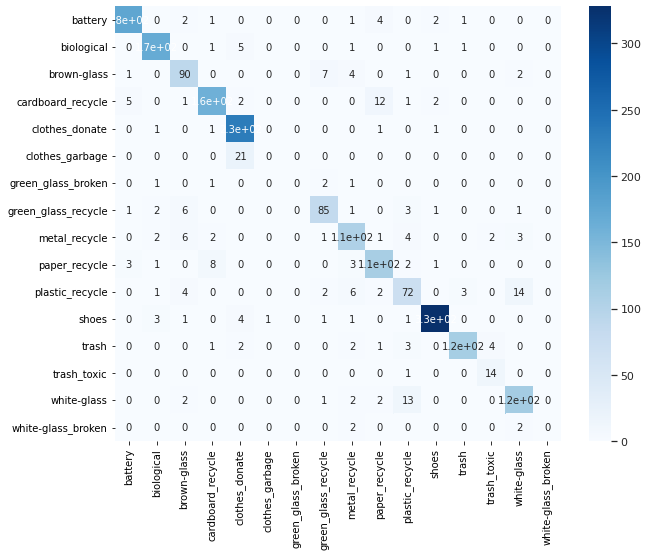

In [17]:
# confusion matrix plot
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(Y_test_class,Y_pred_class)
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = ['battery','biological','brown-glass','cardboard_recycle','clothes_donate','clothes_garbage','green_glass_broken','green_glass_recycle','metal_recycle','paper_recycle','plastic_recycle','shoes','trash','trash_toxic','white-glass','white-glass_broken']
df_cm.index = ['battery','biological','brown-glass','cardboard_recycle','clothes_donate','clothes_garbage','green_glass_broken','green_glass_recycle','metal_recycle','paper_recycle','plastic_recycle','shoes','trash','trash_toxic','white-glass','white-glass_broken']

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size
plt.show()

In [18]:
# classification scores
from sklearn.metrics import classification_report

print(classification_report(Y_test_class,Y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       187
           1       0.94      0.95      0.94       178
           2       0.80      0.86      0.83       105
           3       0.91      0.88      0.89       184
           5       0.87      0.98      0.92       236
           6       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         5
           8       0.86      0.85      0.85       100
           9       0.82      0.83      0.82       127
          10       0.83      0.86      0.85       131
          11       0.71      0.69      0.70       104
          12       0.98      0.96      0.97       340
          13       0.96      0.90      0.93       128
          14       0.70      0.93      0.80        15
          15       0.84      0.85      0.85       137
          16       0.00      0.00      0.00         4

    accuracy                           0.89      2002
   macro avg       0.70   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# bin label
def waste_classify(labels):
  y = np.copy(labels)
  waste_index = [3, 0, 1, 1, 2, 4, 2, 2, 1, 1, 1, 1, 4, 2, 3, 1, 2]
  for i in range(17):
    y = np.where(y == i, waste_index[i], y)
  return y

In [20]:
Y_waste_class_pred = waste_classify(Y_pred_class)
Y_waste_class_test = waste_classify(Y_test_class)

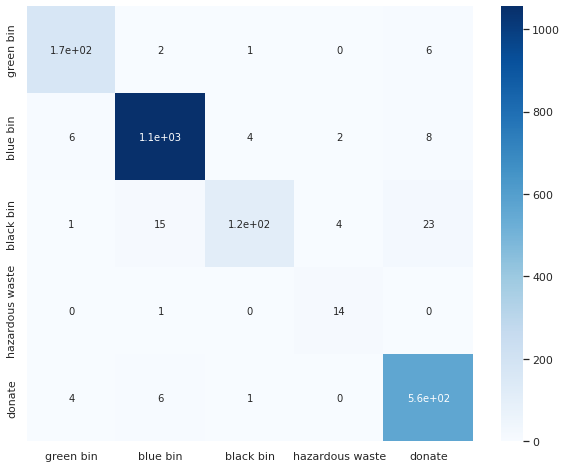

In [21]:
# confusion matrix for bin label
cm=confusion_matrix(Y_waste_class_test,Y_waste_class_pred)
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = ['green bin','blue bin','black bin','hazardous waste','donate']
df_cm.index = ['green bin','blue bin','black bin','hazardous waste','donate']

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size
plt.show()

In [22]:
# classification score for bin label
print(classification_report(Y_waste_class_test,Y_waste_class_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       178
           1       0.98      0.98      0.98      1075
           2       0.95      0.73      0.82       158
           3       0.70      0.93      0.80        15
           4       0.94      0.98      0.96       576

    accuracy                           0.96      2002
   macro avg       0.90      0.91      0.90      2002
weighted avg       0.96      0.96      0.96      2002



In [23]:
# recycle label
def recycle_classify(labels):
  y = np.copy(labels)
  waste_index = [0,1,0,0,0]
  for i in range(5):
    y = np.where(y == i, waste_index[i], y)
  return y

In [24]:
Y_recycle_class_pred = recycle_classify(Y_waste_class_pred)
Y_recycle_class_test = recycle_classify(Y_waste_class_test)

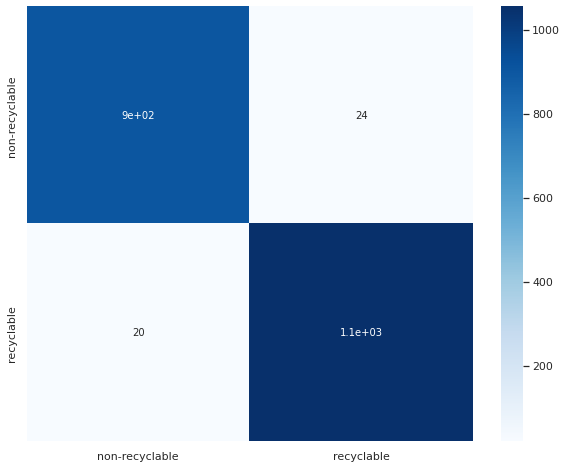

In [25]:
# confusion matrix for recycle label 
cm=confusion_matrix(Y_recycle_class_test,Y_recycle_class_pred)
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = ['non-recyclable','recyclable']
df_cm.index = ['non-recyclable','recyclable']

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size
plt.show()

In [27]:
# classification matrix for cycle label
print(classification_report(Y_recycle_class_test,Y_recycle_class_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       927
           1       0.98      0.98      0.98      1075

    accuracy                           0.98      2002
   macro avg       0.98      0.98      0.98      2002
weighted avg       0.98      0.98      0.98      2002

